**Nikolas Moustakidis**

**AEM: 3743**

**Convolutional Neural Networks**

The Convolutional Neural Network (CNN or ConvNet) is a subtype of Neural Networks that is mainly used for applications in image and speech recognition. Its built-in convolutional layer reduces the high dimensionality of images without losing its information. That is why CNNs are especially suited for this use case

**Convolutional Neural Networks Basic Steps:**
1. Convolution layer, we define a filter/s that determines how large the partial images we are looking at should be, and a step length that decides how many pixels we continue between calculations (convolution between partial images and filters), i.e. how close the partial images are to each other. By taking this step, we have greatly reduced the dimensionality of the image
2. Pooling layer, from a purely computational point of view, the same thing happens here as in the convolution layer, with the difference that we only take either the average or maximum value from the result, depending on the application. This preserves small features in a few pixels that are crucial for the task solution while the size reduces drastically
3. Fully-connected layer, now that we have greatly reduced the dimensions of the image, we can use the tightly meshed layers. Here, the individual sub-images are linked again in order to recognize the connections and carry out the classification.

**Results and CNN comparison with KNN and Nearest Centroid**

As the results show in this notebook the convolutional neural network outperforms by far the classifiers (KNN and NC) which is no surprise ofcourse **(CNN ~90% accuracy, KNN,NC-classifiers ~40% accuracy)**. The CNNs are especially suited for image classification cases where the task is to find patterns and valuable information in an image and distinguise it from the other classes. As I already mentioned the KNN and NC classifiers are not designed for such cases. 

Instead:
* Both classifiers rely on a distance metric to classify the images. This is a 
problem because they suppose that two inputs that are close (in distance) should belong to the same class and when this is violated both KNN and NC underperform

* Euclidean distance between RGB seems fairly meaningless. Two pictures are likely the “same” if we rotate it, adjust the color/saturation/hue, change foreground/background - but all these are considered different under euclidean distance between RGB pixels

* The dimension of each picture 3072=32×32×3 is likely too high, and curse of dimensionality kicks in

All these and many more reasons make the task for the KNN and NC classifier difficult and unsuitable for them to perform on

On the other hand:
* CNNs are very effective in reducing the number of parameters without losing on the quality of models
* For the computer, an image in RGB notation is the summary of three different matrices. For each pixel of the image, it describes what color that pixel displays. We do this by defining the red component in the first matrix, the green component in the second, and then the blue component in the last

**General Plan for CNN:**



1.   Load CIFAR 10 Dataset and apply random augmentations to the training set to boost the performace of the models andhelp the model learn instead of overfit
2.   Implement 3 different models architectures; a simple one, a standard one and a more complex one
3. Train and validate the three models with the same hyperparameters and compare the results
4. Pick the best model performance-wise
5. Add Batch Normalization and Dropout Layers to help the learning process, avoid overfitting and boost the performance
6. Create multiple parameterizations for the model while training, save the best models




**Importing all the appropriate libraries**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from random import randint

**Downloading the CIFAR-10 dataset and applying augmentations**

The output of torchvision datasets are PILImage images of range [0, 1], so we convert them to pytorch tensors in the range of [0,1] and apply augmentations to the training dataset

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Utils and Helper Functions**

* Train function: Runs the training of the model for the whole train dataset and returns the average loss and accuracy
* Validate function: Runs the validation of the model for the whole test dataset and returns the average loss and accuracy
* Plot metrics Function: Plots the losses and accuracies in a figure with subplots

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def train(model, trainloader, optimizer, criterion, device):
  model.train()
  model.to(device)

  train_loss_avg = 0.0
  train_accuracy = 0.0
  total = 0
  correct = 0
  for batch_index, batch in enumerate(trainloader):
    x_batch, y_batch = batch
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    optimizer.zero_grad()

    y_pred = model(x_batch)

    loss = criterion(y_pred, y_batch)
    loss.backward()

    optimizer.step()

    train_loss_avg += loss.item()
    _, pred = torch.max(y_pred, dim=1)
    total += y_batch.size(0)
    correct += torch.sum(pred == y_batch).item()

  train_loss_avg /= (batch_index + 1)
  train_accuracy = correct / total

  return  train_loss_avg, train_accuracy

def validate(model, testloader, optimizer, criterion, device):
  model.eval()
  model.to(device)

  val_loss_avg = 0.0
  val_accuracy = 0.0
  total = 0
  correct = 0
  for batch_index, batch in enumerate(testloader):
    x_batch, y_batch = batch
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    optimizer.zero_grad()

    y_pred = model(x_batch)

    loss = criterion(y_pred, y_batch)

    val_loss_avg += loss.item()
    _, pred = torch.max(y_pred, dim=1)
    total += y_batch.size(0)
    correct += torch.sum(pred == y_batch).item()

  val_loss_avg /= (batch_index + 1)
  val_accuracy = correct / total

  return  val_loss_avg, val_accuracy

def plot_metrics(index, model_name, train_loss, train_accuracy, val_loss, val_accuracy):
  axis[0,index].set_title(f'{model_name}\nTraining Validation Loss')
  axis[0,index].plot(train_loss,  marker='o', label="Training Loss")
  axis[0,index].plot(val_loss,  marker='o', label="Validation Loss")
  axis[0,index].set(xlabel='Epoch', ylabel='Loss')
  axis[0,index].legend()

  axis[1,index].set_title(f'{model_name}\nTraining Validation Accuracy')
  axis[1,index].plot(train_accuracy, marker='o', label="Training Accuracy")
  axis[1,index].plot(val_accuracy, marker='o', label="Validation Accuracy")
  axis[1,index].set(xlabel='Epoch', ylabel='Accuracy')
  axis[1,index].legend()

**Different model architectures**

I implemented 3 different architectures of CNN models to compare them and select one to continue optimizing to achieve better results

* **SimpleCNN:** A simple network containg only one convolution and two linear layers

* **BaseCNN:** A shallow network containg three convolutions and three linear layers

* **DoubleCNN:** A slightly more complex network containg three double convolutions (6 in total) and four linear layers

In [4]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

        nn.Flatten(),

        nn.Linear(32*16*16, 1024),
        nn.ReLU(),

        nn.Linear(1024, 10))
      
  def forward(self, x):
    return self.network(x)

class BaseCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 128 x 4 x 4

      nn.Flatten(),
      
      nn.Linear(128*4*4, 1024),
      nn.ReLU(),

      nn.Linear(1024, 512),
      nn.ReLU(),

      nn.Linear(512, 10))
      
  def forward(self, x):
    return self.network(x)

class DoubleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

      nn.Flatten(), 

      nn.Linear(256*4*4, 1024),
      nn.ReLU(),

      nn.Linear(1024, 512),
      nn.ReLU(),

      nn.Linear(512, 256),
      nn.ReLU(),
      
      nn.Linear(256, 10))
      
  def forward(self, x):
    return self.network(x)

**Main training and validation script**

* Train and validate the three models I defined previously
* Plot the results to compare and select the best one to move on with optimizations

Training model:  DoubleCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Lin

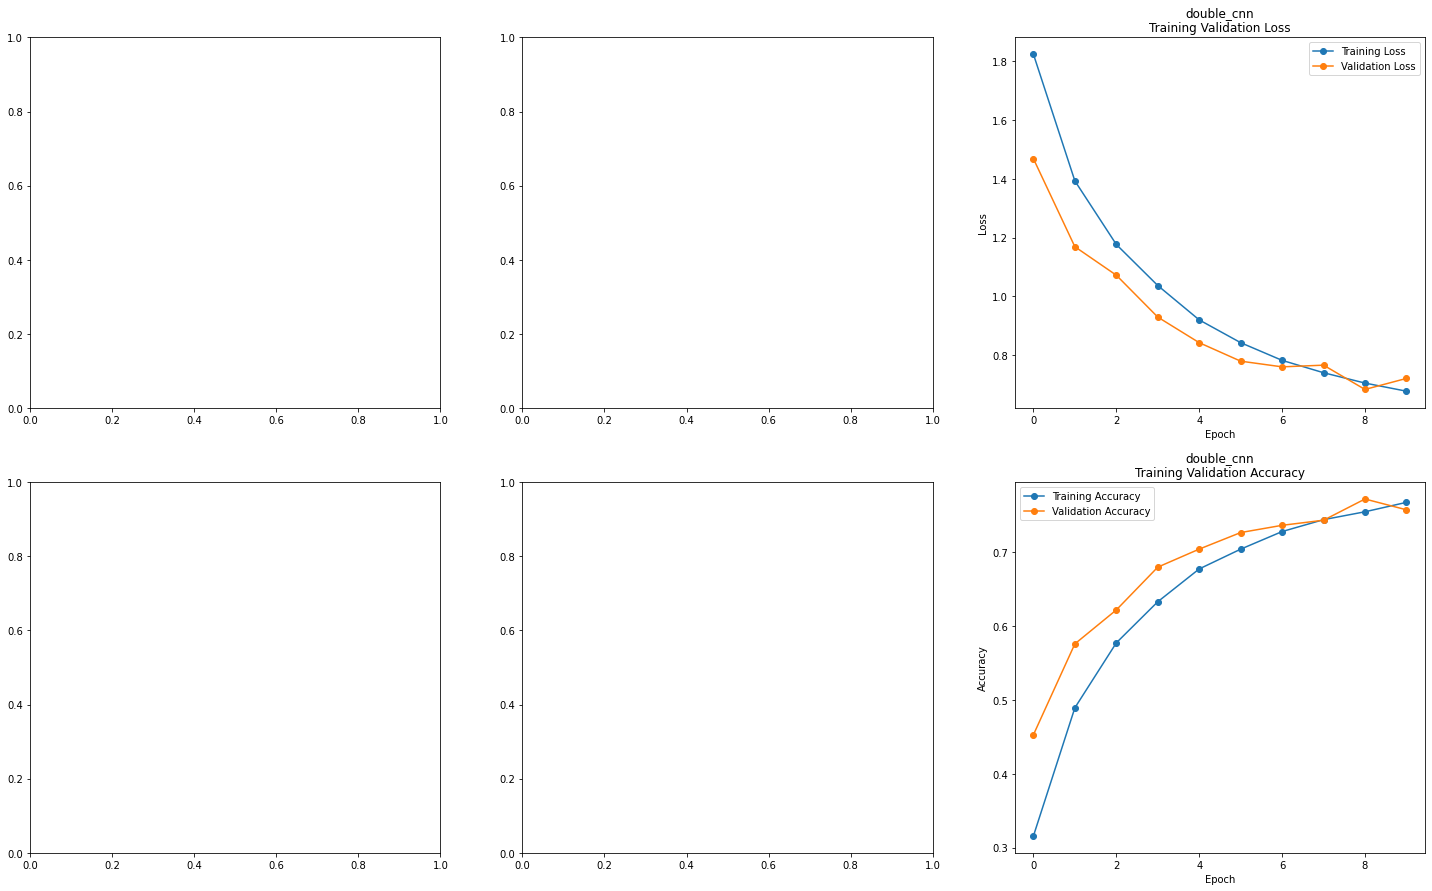

In [5]:
runs = 3
figure, axis = plt.subplots(2, 3, figsize=(25, 15))

for idx in range(runs):
  start = time.time()

  if idx == 0:
    model = SimpleCNN()
    model_name = 'simple_cnn'
    # continue
  elif idx == 1:
    model = BaseCNN()
    model_name = 'base_cnn'
    # continue
  else:
    model = DoubleCNN()
    model_name = 'double_cnn'
  
  print('Training model: ', model)


  # optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
  epochs = 10
  lr = 1e-3
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
    
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  train_loss_list = []
  train_accuracy_list = []

  val_loss_list = []
  val_accuracy_list = []

  for epoch in range(epochs):
    train_loss, train_accuracy = train(model, trainloader, optimizer, criterion, device)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    val_loss, val_accuracy = validate(model, testloader, optimizer, criterion, device)

    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    print('Epoch: {0:3d} | train_loss: {1:2f} | train_accuracy: {2:2f} | val_loss: {3:2f} | val_accuracy: {4:2f}'.format(epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))

  end = time.time()

  print(f'{model_name} model total training-validation time: {(end-start) / 60} minutes')

  plot_metrics(idx, model_name, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

**Results Analysis**

* All models perform good in the short span of 10 epochs and continuously drop the loss and increase the accuracy
* In every model the accuracy and loss in the validation set outperforms the ones in the training set which is a really good signal meaning that our models actually learn and don't overfit to the data
* It seems that the DoubleCNN model achieves slightly better results along with the BaseCNN in terms of accuracy and loss. Of course we could use more metrics such as Recall, Precision, F1 score to have a more complete set of metrics to evaluate the performance more accurately. But the accuracy and loss work as a good indicator for now
* In that manner we will select the final model (DoubleCNN) to continue with optimizing to achieve better results

**Changing the model Architecture**
*   Adding Batch Normalization to normalize the contributions to each layer for every mini-batch in order to achive a better learning process
*   Adding Dropout Layers to help the model avoid overfitting
* Add cb (model structure) and dp (dropout rate) parameters to dynamically change the model architecture and find what works best

These changes will have an impact both in achieving a better peak performance, as well as help the learning process of the model which means converging faster and avoiding overfitting

I will use the cb and dp parameters later on to optimize the model during training

In [6]:
class DoubleCNN(nn.Module):
  def __init__(self, cb=[32,64,128,256], dp=0.3):
    super().__init__()
    self.network = nn.Sequential(
      nn.Conv2d(3, cb[0], kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(cb[0]),
      nn.ReLU(),
      nn.Conv2d(cb[0], cb[1], kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(cb[1]),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
      nn.Dropout(dp),

      nn.Conv2d(cb[1], cb[2], kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(cb[2]),
      nn.ReLU(),
      nn.Conv2d(cb[2], cb[2], kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(cb[2]),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
      nn.Dropout(dp),

      nn.Conv2d(cb[2], cb[3], kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(cb[3]),
      nn.ReLU(),
      nn.Conv2d(cb[3], cb[3], kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(cb[3]),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
      nn.Dropout(dp),

      nn.Flatten(), 

      nn.Linear(cb[3]*4*4, 1024),
      nn.ReLU(),

      nn.Linear(1024, 512),
      nn.ReLU(),

      nn.Linear(512, 256),
      nn.ReLU(),
      
      nn.Linear(256, 10))
      
  def forward(self, x):
    return self.network(x)

Training and Validating with the addition of Batch Normalization and Dropout Layers

Training model:  DoubleCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): D

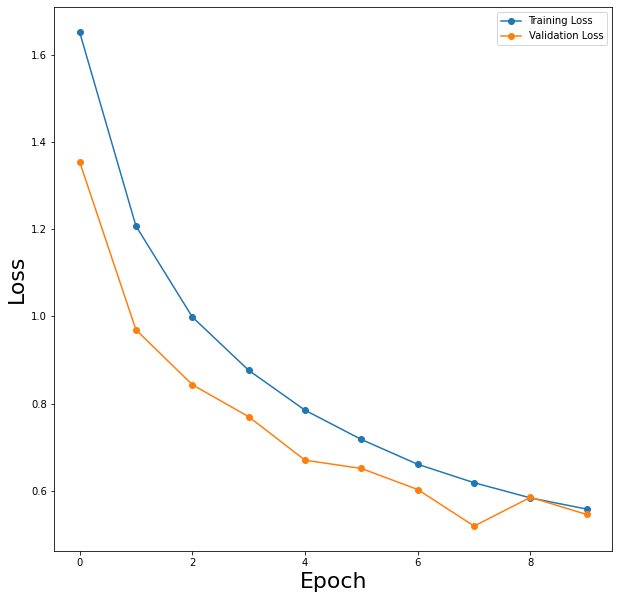

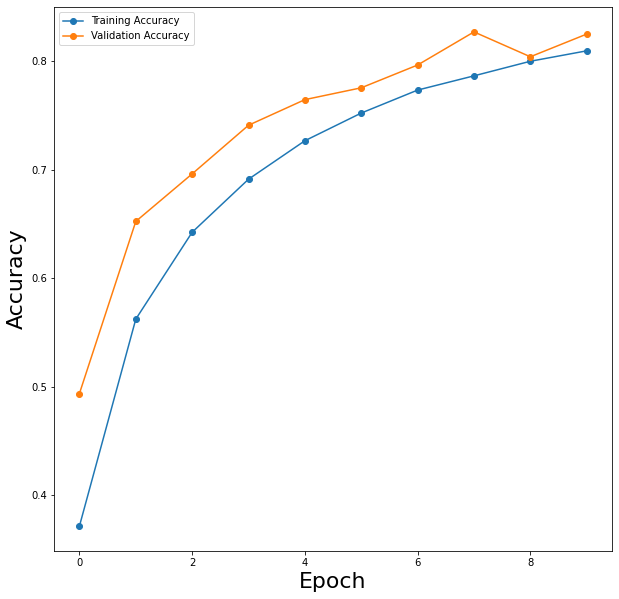

In [7]:
model = DoubleCNN()
model_name = 'double_cnn'

print('Training model: ', model)

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
epochs = 10
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

for epoch in range(epochs):
  train_loss, train_accuracy = train(model, trainloader, optimizer, criterion, device)

  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  val_loss, val_accuracy = validate(model, testloader, optimizer, criterion, device)

  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  print('Epoch: {0:3d} | train_loss: {1:2f} | train_accuracy: {2:2f} | val_loss: {3:2f} | val_accuracy: {4:2f}'.format(epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))

plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(val_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('Loss', fontsize=22)
plt.xlabel('Epoch', fontsize=22)
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(train_accuracy_list,  marker='o', label="Training Accuracy")
plt.plot(val_accuracy_list,  marker='o', label="Validation Accuracy")
plt.ylabel('Accuracy', fontsize=22)
plt.xlabel('Epoch', fontsize=22)
plt.legend()
plt.show()

**Testing the model in a few random samples and visualing the predictions**

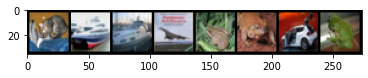

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 
Predicted:  cat   ship  ship  plane frog  frog  car   frog 


In [8]:
def predict_image(images, model):
  model.to(device)
  images = images.to(device)
  # Get predictions from model
  yb = model(images)
  # Pick index with highest probability
  _, preds  = torch.max(yb, dim=1)
  # Retrieve the class label
  return preds

test_loader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

predicted = predict_image(images, model)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

**Training and Validating multiple model architectures of DoubleCNN by performing a custom search for not only hyperparameter tuning but also for oprimizing the model architecture (tuning the number of feature maps in each convolutional block and tuning the dropout rates)**
* The model during testing achieved more than 90% accuracy in the validation set which is a really good performance overall
* In real life conditions I would set "runs" to 500 and "epochs" to 200 in order to let the model adapt itself and find the best possible architecture and parameters to achieve the best results
* Here I set "runs" to 5 and "epochs" to 30 to speed up the whole procedure
* The idea is that I will train 5 different models each for 30 epochs. If the model is stuck with the same validation accuracy for 10 consecutive epochs then I reduce the learning rate otherwise I save the best model and continue training

In [9]:
runs = 5
os.mkdir('./saved_models')
for idx in range(runs):
  print('Training model: ', idx)
  epochs = 30
  lr = np.random.uniform(low=5e-4, high=1e-2, size=(1,))[0]
  dropout = np.random.uniform(low=0.3, high=0.5, size=(1,))[0]
  model_struct = [randint(35, 50), randint(25, 60), randint(50, 120), randint(100, 200)] #[32, 64, 128, 256]

  model_save_path = os.path.join('./saved_models/', 'CIFAR_Classifier_'
                                       + str(lr) + '_'
                                       + str(epochs) + '_'
                                       + str(dropout) + '_'
                                       + 'kernels' + str(model_struct[0]) + '_' + str(model_struct[1])
                                       + '_' + str(model_struct[2]) + '_' + str(model_struct[3]) + '.pt')

  print('Defined Net')
  print('Model Structure: ', model_struct)
  print('Learning rate: ', lr)
  print('Dropout rate: ', dropout)

  model = DoubleCNN(cb=model_struct, dp=dropout)
  model_name = 'double_cnn'

  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  lowest_loss = 1e6
  highest_accuracy = -1
  count = 0

  train_loss_list = []
  train_accuracy_list = []

  val_loss_list = []
  val_accuracy_list = []

  for epoch in range(epochs):
    count += 1
    train_loss, train_accuracy = train(model, trainloader, optimizer, criterion, device)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    val_loss, val_accuracy = validate(model, testloader, optimizer, criterion, device)

    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    if count == 10:
      count = 0
      model = DoubleCNN(cb=model_struct, drop=dropout)  # get a new instance
      model.load_state_dict(best_model.state_dict())

      lr = lr / 2

      print('new learning rate: ', lr)
      for param_group in optimizer.param_groups:
          param_group['lr'] = lr

    if val_accuracy > highest_accuracy:
      count = 0
      best_model = DoubleCNN(cb=model_struct, dp=dropout)  # get a new instance
      best_model.load_state_dict(model.state_dict())

      highest_accuracy = val_accuracy

      torch.save(model.state_dict(), model_save_path)

      print('Epoch: {0:3d} | train_loss: {1:2f} | train_accuracy: {2:2f} | val_loss: {3:2f} | val_accuracy: {4:2f}'.format(epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))
      print('Best Model Saved')

plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(val_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('Loss', fontsize=22)
plt.xlabel('Epoch', fontsize=22)
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(train_accuracy_list,  marker='o', label="Training Accuracy")
plt.plot(val_accuracy_list,  marker='o', label="Validation Accuracy")
plt.ylabel('Accuracy', fontsize=22)
plt.xlabel('Epoch', fontsize=22)
plt.legend()
plt.show()

Training model:  0
Defined Net
Model Structure:  [38, 45, 110, 186]
Learning rate:  0.0008773259757064614
Dropout rate:  0.38076935825413016
Epoch:   1 | train_loss: 1.613153 | train_accuracy: 0.391740 | val_loss: 1.220437 | val_accuracy: 0.559400
Best Model Saved
Epoch:   2 | train_loss: 1.193782 | train_accuracy: 0.571820 | val_loss: 1.000092 | val_accuracy: 0.644200
Best Model Saved
Epoch:   3 | train_loss: 1.016085 | train_accuracy: 0.637680 | val_loss: 0.968389 | val_accuracy: 0.669800
Best Model Saved
Epoch:   4 | train_loss: 0.908658 | train_accuracy: 0.680600 | val_loss: 0.831497 | val_accuracy: 0.709600
Best Model Saved
Epoch:   5 | train_loss: 0.836163 | train_accuracy: 0.704800 | val_loss: 0.734229 | val_accuracy: 0.748300
Best Model Saved
Epoch:   6 | train_loss: 0.779139 | train_accuracy: 0.728600 | val_loss: 0.691699 | val_accuracy: 0.766200
Best Model Saved
Epoch:   7 | train_loss: 0.731210 | train_accuracy: 0.744380 | val_loss: 0.652813 | val_accuracy: 0.777700
Best Mod

KeyboardInterrupt: ignored